In [1]:
# custom libraries

from SPECTRA_processing_utils import *
from scrnaseq_preprocessing_utils import *

# packages
import scanpy as sc
import scanpy.external as sce
import anndata as anndata
#import diffxpy.api as de
from anndata import AnnData
import time
import os
import numpy as np
import seaborn as sns
import pandas as pd
import re
import h5py
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.font_manager
import glob
from collections import OrderedDict
from scipy.sparse import csr_matrix
from scanpy.external.pp import magic
from scipy.stats import zscore
import scipy.cluster.hierarchy as hc
from statistics import median
import math
from typing import Union

import numpy.matlib

In [2]:
import cytopus as cp


In [7]:
DATA_DIR = '/path_to_data/'
fig_save_dir = '/path_to_figures/'

# load data 

In [11]:
adata_path = DATA_DIR + '/TIL-X-NSCLC-X-scRNAseq-X-2022-X-Salcher-X-10.1016_j.ccell.2022.10.008.h5ad'
adata_save_path = DATA_DIR +  'TIL-X-NSCLC-X-scRNAseq-X-2022-X-Salcher-X-10.1016_j.ccell.2022.10.008_annotated.h5ad'

In [9]:
adata = sc.read(adata_path)
adata

Only considering the two last: ['.008', '.h5ad'].
Only considering the two last: ['.008', '.h5ad'].


AnnData object with n_obs × n_vars = 1283972 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts'

In [11]:
G = cp.kb.KnowledgeBase()


KnowledgeBase object containing 75 cell types and 201 cellular processes



In [16]:
cell_dict = G.identities
cell_dict.keys()

dict_keys(['TCM', 'TSCM', 'CD8-T_KLRG1pos-effector', 'TEM', 'FDC', 'Langerhans', 'B-memory-DN', 'Treg', 'B-memory-non-switched', 'CD56bright-NK', 'mono', 'B-pb-t1', 'NK-adaptive', 'mast', 'TRM', 'CD4-T', 'cDC2', 'p-DC', 'GC-B', 'B-memory-IgM-MZ', 'CD8-T', 'NK', 'T', 'ILC2', 'mo-DC', 'capillary', 'endo-systemic-venous', 'cDC3', 'B', 'gran', 'CD56dim-NK', 'cDC1', 'B-pb-t2', 'Lti', 'plasma', 'B-pb-mature', 'gdT', 'plasma-blast', 'CD8-T-progenitor-exhausted', 'Mac', 'B-memory-switched', 'ILC1', 'ILC3-NCRpos', 'CD8-T_KLRG1neg-effector', 'lung-endo-venous', 'ILC3-NCRneg', 'B-memory', 'endo-aerocyte', 'T-naive', 'B-naive'])

In [78]:
epi = ['Alveolar cell type 1',
 'Alveolar cell type 2',
       'Cancer cells',
 'Ciliated',
 'Club', 'ROS1+ healthy epithelial', 'Transitional Club/AT2',]
BP = ['B cell',
 'B cell dividing','Plasma cell',
 'Plasma cell dividing',]
TNK = ['NK cell',
 'NK cell dividing','NK cell',
 'NK cell dividing', 'T cell CD4',
 'T cell CD4 dividing',
 'T cell CD8 activated',
 'T cell CD8 dividing',
 'T cell CD8 effector memory',
 'T cell CD8 naive',
 'T cell CD8 terminally exhausted',
 'T cell NK-like',
 'T cell regulatory',]
M = ['DC mature', 'Macrophage',
 'Macrophage alveolar',
 'Mast cell','Monocyte classical',
 'Monocyte non-classical',
 'Myeloid dividing','cDC1',
 'cDC2',
 'pDC', 'Neutrophils',]
stroma = [ 'Fibroblast adventitial',
 'Fibroblast alveolar',
 'Fibroblast peribronchial','Endothelial cell arterial',
 'Endothelial cell capillary',
 'Endothelial cell lymphatic',
 'Endothelial cell venous','Mesothelial', 'Pericyte', 'Smooth muscle cell',
 'Stromal dividing',]

In [74]:
TNK_dict = {k:v for k,v in cell_dict.items() if k in ['TCM', 'TSCM', 'CD8-T_KLRG1pos-effector', 'TEM', 'Treg', 'CD56bright-NK', 'NK-adaptive', 'TRM', 'CD4-T',
     'CD8-T', 'NK', 'T', 'ILC2','CD56dim-NK','Lti', 'gdT', 'CD8-T-progenitor-exhausted','ILC1', 'ILC3-NCRpos', 'CD8-T_KLRG1neg-effector', 
      'ILC3-NCRneg', 'T-naive',]}



### change .var_names into gene names instead of ENSEMBL IDs


In [35]:
adata.var_names = adata.var['feature_name']

In [42]:
adata.raw.var['ENSEMBL'] = adata.raw.var_names

In [47]:
adata.raw.var.index = adata.raw.var['feature_name']

In [37]:
adata.var

,is_highly_variable,mito,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,feature_is_filtered,feature_name,feature_reference,feature_biotype
feature_name,,,,,,,,,,
A1BG,True,False,86866,2.527138,90.681054,2355657.0,False,A1BG,NCBITaxon:9606,gene
A1BG-AS1,True,False,12257,0.369194,98.685074,344142.0,False,A1BG-AS1,NCBITaxon:9606,gene
A2M,True,False,122241,22.579874,86.886039,21047694.0,False,A2M,NCBITaxon:9606,gene
A2M-AS1,False,False,8827,0.172223,99.053043,160537.0,False,A2M-AS1,NCBITaxon:9606,gene
A2ML1,True,False,5096,0.038011,99.453303,35432.0,False,A2ML1,NCBITaxon:9606,gene
...,...,...,...,...,...,...,...,...,...,...
ZXDC,False,False,43291,0.442399,95.355760,412380.0,False,ZXDC,NCBITaxon:9606,gene
ZYG11A,False,False,3517,0.009742,99.622698,9081.0,False,ZYG11A,NCBITaxon:9606,gene
ZYG11B,False,False,71512,0.275276,92.328224,256597.0,False,ZYG11B,NCBITaxon:9606,gene


# plot markers

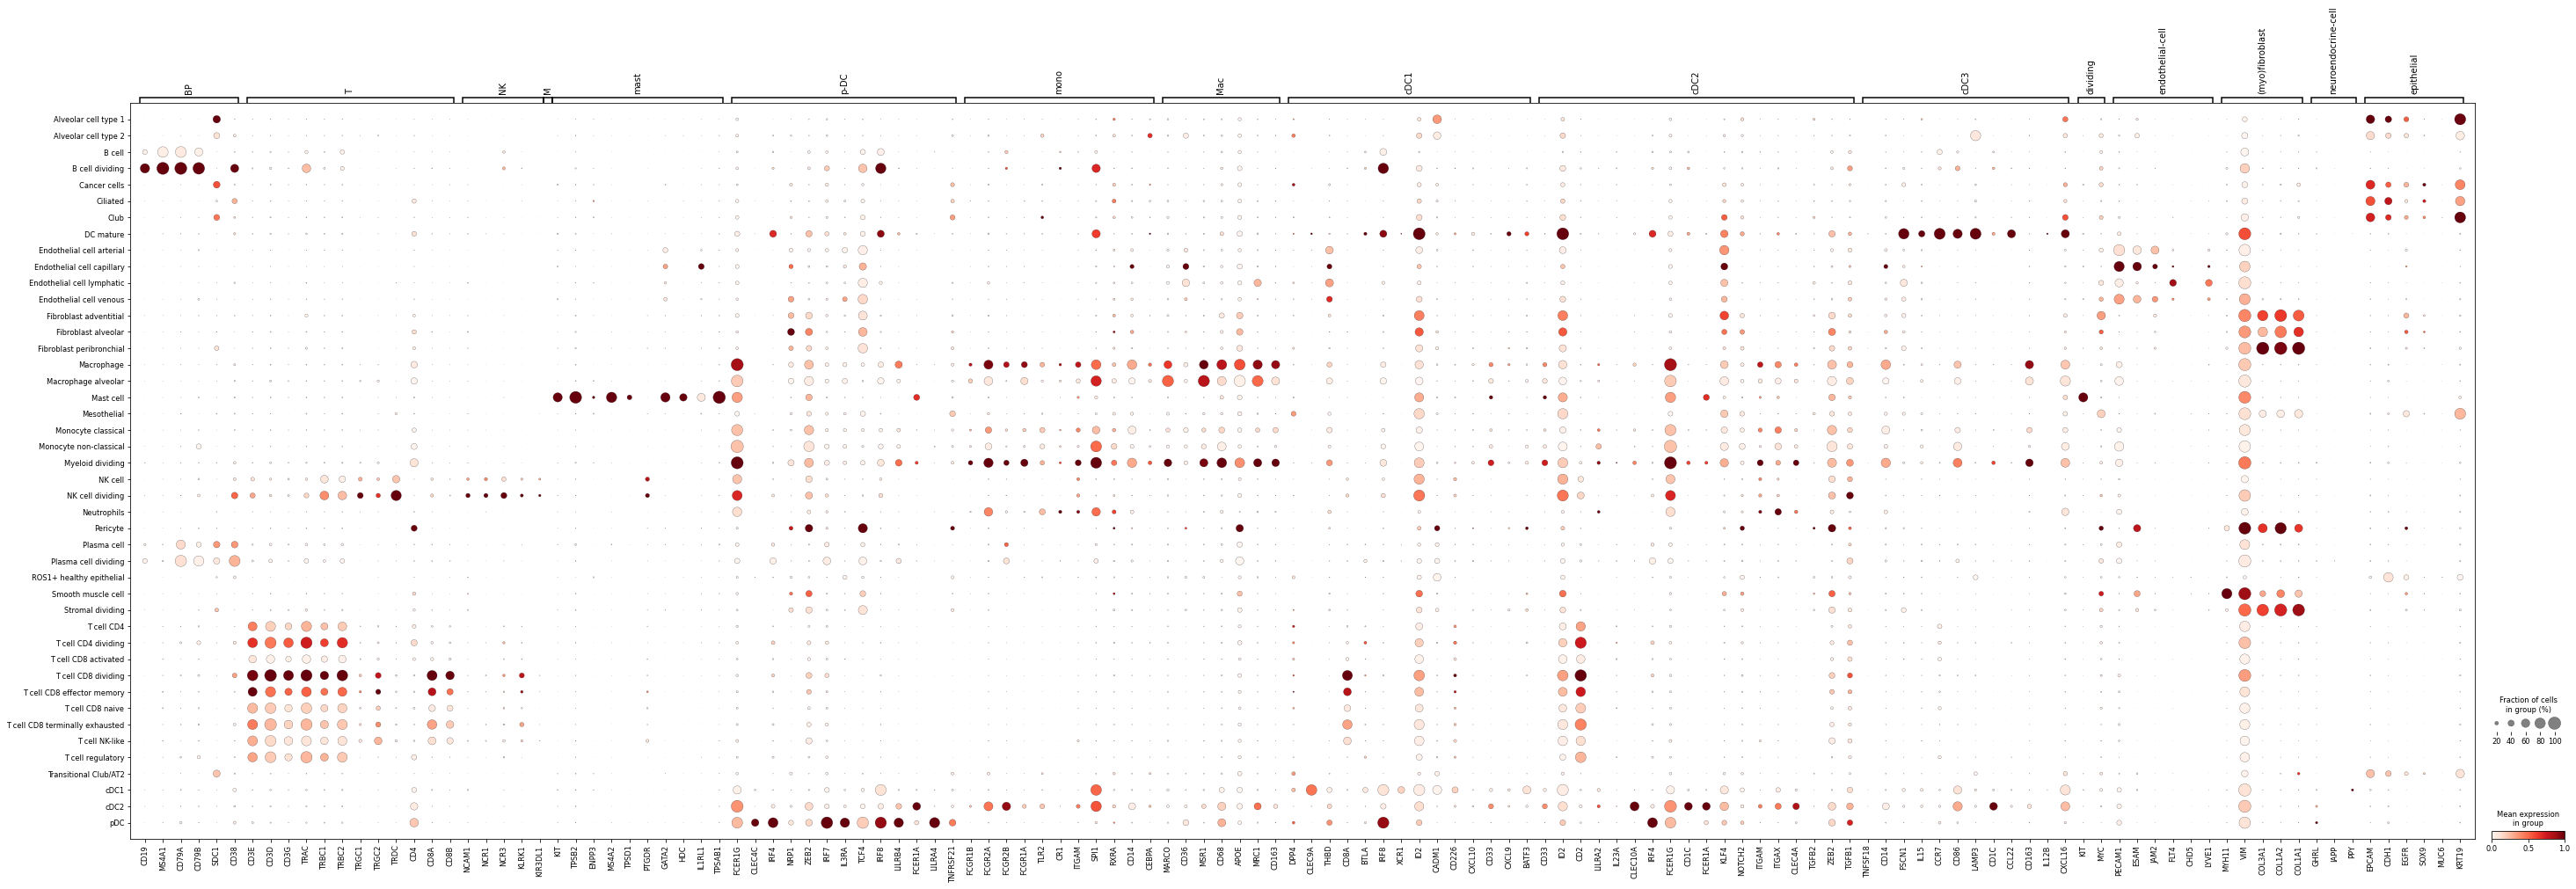

In [68]:
basic_markers = {'BP':['CD19','MS4A1','CD79A','CD79B','SDC1','CD38'],
                'T':['CD3E','CD3D','CD3G','TRAC','TRBC1','TRBC2','TRGC1','TRGC2','TRDC','CD4','CD8A','CD8B'],
                'NK':['NCAM1','NCR1','NCR2','NCR3','KLRK1','KIR3DL1'],
                'M':[],
                'mast':['KIT',
 'TPSB2',
 'ENPP3',
 'MS4A2',
 'TPSD1',
 'PTGDR',
 'GATA2',
 'HDC',
 'IL1RL1',
 'TPSAB1'],
                'p-DC':['FCER1G',
 'CLEC4C',
 'IRF4',
 'NRP1',
 'ZEB2',
 'IRF7',
 'IL3RA',
 'TCF4',
 'IRF8',
 'LILRB4',
 'FCER1A',
 'LILRA4',
 'TNFRSF21'],
                'mono':['FCGR1B',
 'FCGR2A',
 'FCGR2B',
 'FCGR1A',
 'TLR2',
 'CR1',
 'ITGAM',
 'SPI1',
 'RXRA',
 'CD14',
 'CEBPA'],
                 'Mac':['MARCO', 'CD36', 'MSR1', 'CD68', 'APOE', 'MRC1', 'CD163'],
                 'cDC1':['DPP4',
 'CLEC9A',
 'THBD',
 'CD8A',
 'BTLA',
 'IRF8',
 'XCR1',
 'ID2',
 'CADM1',
 'CD226',
 'CXCL10',
 'CD33',
 'CXCL9',
 'BATF3'],
                 'cDC2':['CD33',
 'ID2',
 'CD2',
 'LILRA2',
 'IL23A',
 'CLEC10A',
 'IRF4',
 'FCER1G',
 'CD1C',
 'FCER1A',
 'KLF4',
 'NOTCH2',
 'ITGAM',
 'ITGAX',
 'CLEC4A',
 'TGFB2',
 'ZEB2',
 'TGFB1'],
                 'cDC3':['TNFSF18',
 'CD14',
 'FSCN1',
 'IL15',
 'CCR7',
 'CD86',
 'LAMP3',
 'CD1C',
 'CCL22',
 'CD163',
 'IL12B',
 'CXCL16']   ,
                 'dividing':['KIT','MYC'],
                 'endothelial-cell':['PECAM1','ESAM','JAM2','FLT4','CHD5','LYVE1'],
           '(myo)fibroblast':['MYH11','VIM','COL3A1','COL1A2','COL1A1'],
           'neuroendocrine-cell':['GLP1R','GLPR2R','GHRL','SST','IAPP','INS','GCG','PPY'],
           'epithelial':['EPCAM','CDH1','EGFR','SOX9','MUC6','MUC5','KRT19']
                 
                }
basic_markers_clean = {}
for k,v in basic_markers.items():
    basic_markers_clean[k] = [x for x in v if x in adata.var_names]
sc.pl.dotplot(adata,basic_markers_clean, groupby='ann_fine', dendrogram=False,
                 layer=None, standard_scale ='var')

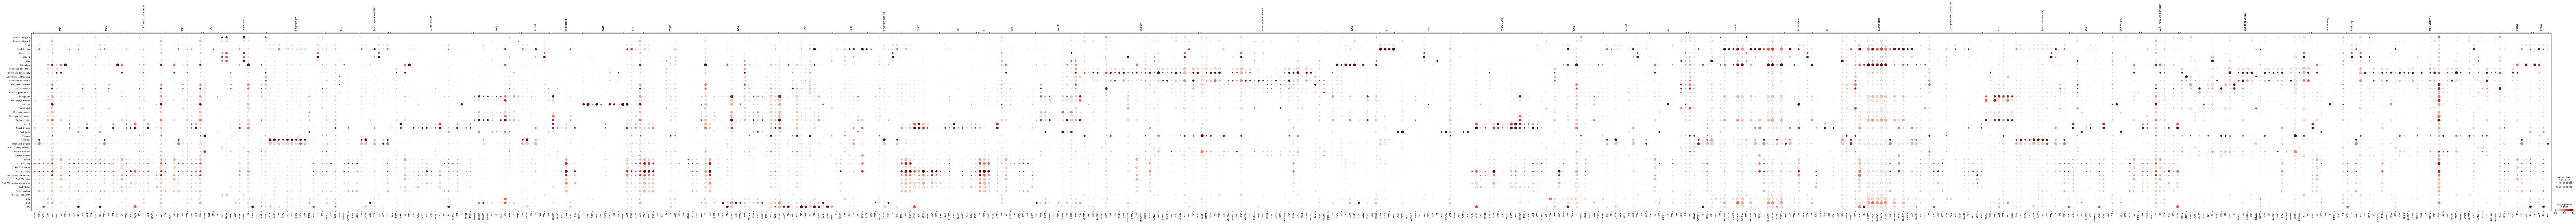

In [48]:
cell_dict_clean = {}

for k,v in cell_dict.items():
    cell_dict_clean[k] = [x for x in v if x in adata.var_names]
sc.pl.dotplot(adata,cell_dict_clean, groupby='ann_fine', dendrogram=False,
                 layer=None, standard_scale ='var')

## T/ILC cells

In [79]:
adata_TNK = adata[adata.obs['ann_fine'].isin(TNK)]
adata_TNK

View of AnnData object with n_obs × n_vars = 474705 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_

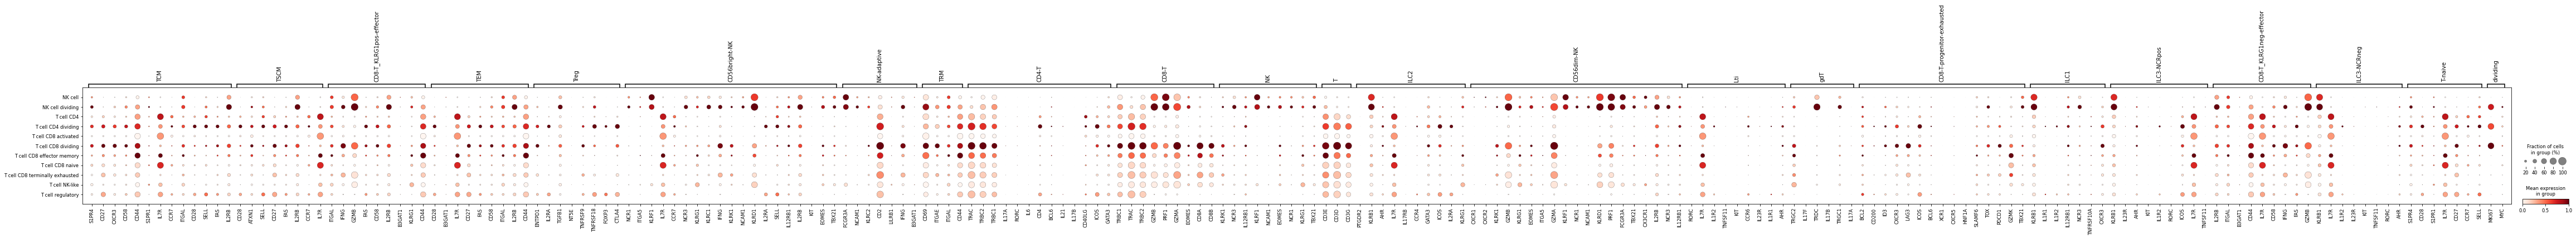

In [83]:
TNK_dict_clean = {}

for k,v in TNK_dict.items():
    TNK_dict_clean[k] = [x for x in v if x in adata.var_names]
TNK_dict_clean['dividing'] = ['MKI67','MYC']
sc.pl.dotplot(adata_TNK,TNK_dict_clean, groupby='ann_fine', dendrogram=False,
                 layer=None, standard_scale ='var')

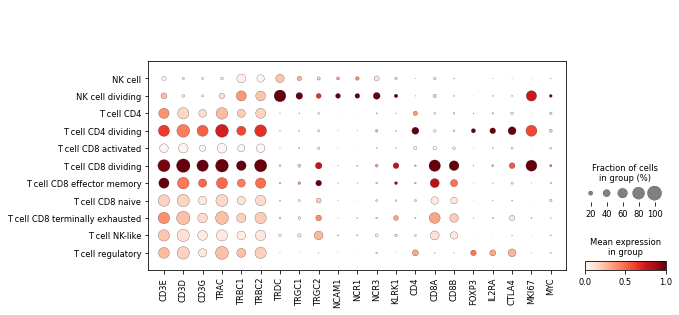

In [93]:
sc.pl.dotplot(adata_TNK,['CD3E','CD3D','CD3G','TRAC','TRBC1','TRBC2',
                         'TRDC','TRGC1','TRGC2','NCAM1','NCR1','NCR3','KLRK1',
                        'CD4','CD8A','CD8B','FOXP3','IL2RA','CTLA4','MKI67','MYC'], groupby='ann_fine', dendrogram=False,
                 layer=None, standard_scale ='var')

## B/plasma cells

In [95]:
adata_BP = adata[adata.obs['ann_fine'].isin(BP)]
adata_BP

View of AnnData object with n_obs × n_vars = 104545 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_

In [98]:
adata_BP[adata_BP.obs['ann_fine']=='B cell']

View of AnnData object with n_obs × n_vars = 68430 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_c

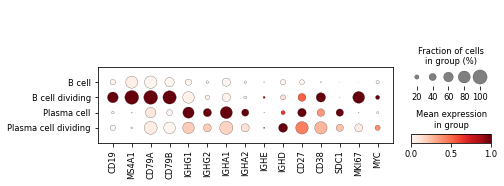

In [96]:
sc.pl.dotplot(adata_BP,['CD19','MS4A1','CD79A','CD79B','IGHG1','IGHG2','IGHA1','IGHA2','IGHE',
                        'IGHD','CD27','CD38','SDC1','MKI67','MYC'], groupby='ann_fine', dendrogram=False,
                 layer=None, standard_scale ='var')

## myeloid cells

In [99]:
adata_M = adata[adata.obs['ann_fine'].isin(M)]
adata_M

View of AnnData object with n_obs × n_vars = 443751 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_

In [104]:
M_dict = {k:v for k,v in cell_dict.items() if k in ['FDC', 'Langerhans','mono','mast', 'cDC2', 'p-DC', 'mo-DC','cDC3','gran', 'cDC1','Mac',]}

In [120]:
G.identities['mono']

['FCGR1B',
 'FCGR2A',
 'FCGR2B',
 'FCGR1A',
 'TLR2',
 'CR1',
 'ITGAM',
 'SPI1',
 'RXRA',
 'CD14',
 'CEBPA']

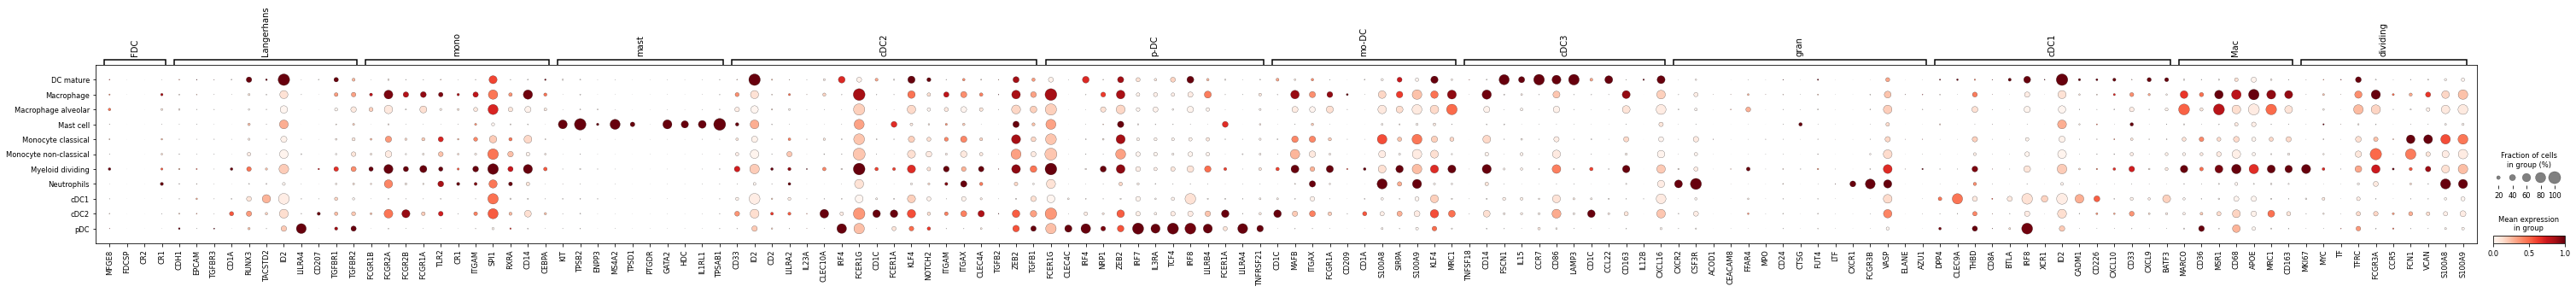

In [123]:
M_dict_clean = {}

for k,v in M_dict.items():
    M_dict_clean[k] = [x for x in v if x in adata.var_names]
M_dict_clean['dividing'] = ['MKI67','MYC','TF','TFRC','FCGR3A','CCR5','FCN1','VCAN','S100A8','S100A9']

sc.pl.dotplot(adata_M,M_dict_clean, groupby='ann_fine', dendrogram=False,
                 layer=None, standard_scale ='var')

## stroma cells

In [112]:
adata_stroma = adata[adata.obs['ann_fine'].isin(stroma)]
adata_stroma

/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


View of AnnData object with n_obs × n_vars = 70557 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_c

In [113]:
G.identities.keys()

dict_keys(['TCM', 'TSCM', 'CD8-T_KLRG1pos-effector', 'TEM', 'FDC', 'Langerhans', 'B-memory-DN', 'Treg', 'B-memory-non-switched', 'CD56bright-NK', 'mono', 'B-pb-t1', 'NK-adaptive', 'mast', 'TRM', 'CD4-T', 'cDC2', 'p-DC', 'GC-B', 'B-memory-IgM-MZ', 'CD8-T', 'NK', 'T', 'ILC2', 'mo-DC', 'capillary', 'endo-systemic-venous', 'cDC3', 'B', 'gran', 'CD56dim-NK', 'cDC1', 'B-pb-t2', 'Lti', 'plasma', 'B-pb-mature', 'gdT', 'plasma-blast', 'CD8-T-progenitor-exhausted', 'Mac', 'B-memory-switched', 'ILC1', 'ILC3-NCRpos', 'CD8-T_KLRG1neg-effector', 'lung-endo-venous', 'ILC3-NCRneg', 'B-memory', 'endo-aerocyte', 'T-naive', 'B-naive'])

In [114]:
stroma_dict = {k:v for k,v in cell_dict.items() if k in [ 'capillary', 'endo-systemic-venous',
                                                        'lung-endo-venous']}



In [ ]:
lymphatic =['PKHD1L1',
'MMRN1',
'FLT4',
'TFF3',
'SEMA3D'
'TBX1',
'PROX1',
'RELN',
'LINC02147',
'TM4SF18',
'PDPN',
'SNCG',
'CCL21',
'LYVE1',
'KLHL4',
'SCN3B']

arterial = ['CLEC14A',
'CLDN10',
'ITM2A',
'EPAS1',
'LTBP4',
'CXCL12',
'DKK2',
'HEY1',
'IGFBP3',
'SHROOM4',
'PCDH17',
'FBLN5',
'BMPR2',
'AQP1',
'BMX',
'IFI27',
'SLCO2A1',
'FLT1',
'SOX5',
'SERPINE2',
'SEMA3G',
'GJA5',
'ESAM',
'LIMS2',
'ENG',
'ADGRL4'
]
capillary = ['ADGRF5',
'IL18R1',
'CD36',
'SLCO2A1',
'NRXN3',
'RGCC',
'ESAM',
'FLT1',
'BTNL9',
'CLEC14A',
'ARHGAP18',
'SLC6A4',
'IL7R',
'SHROOM4',
'BMPR2',
'ITM2A',
'KIAA1217',
'EPAS1',
'PCDH17',
'ADGRL4',
'LIMS2',
'AQP1',
'ADGRL2',
'IFI27',
'AFF3',
'ENG',
'FCN3']
systemic_venous = ['IGFBP7',
'BMPR2',
'ESAM',
'VWF',
'AQP1',
'EBF1',
'ZNF385D',
'PCDH17',
'LIMS2',
'IFI27',
'ADGRL4',
'FLT1',
'TPD52L1',
'PLVAP',
'VWA1',
'CPXM2',
'OLFM1',
'ACKR1',
'FLRT2',
'SHROOM4',
'ENG',
'ITM2A',
'EPAS1',
'PDE7B',
'CLEC14A',
'SLCO2A1',
'TSHZ2',
'MCTP1',
'COL15A1']

tip =['RGCC','RAMP3'] 

HEC = ['CHST4','FLT4','TBX1','GLYCAM1','CCL21','MADCAM1']
pericyte = ['RGS5','CSPG4','ABCC9','KCNJ8']
regenerating = ['ATF3','CDH5','MKI67','TEK']
stellate = [ 'NGFR','FCN3','NTRK3','NCAM1','RBP1','CYGB','LRAT','VIM','NTF3',]#10.1007/s00535-017-1404-4
sinusoid = ['ENG','CD36','FCGR2A','STAB1','STAB2','SCARB1','SCARF1','CLEC4M','LYVE1','LRP1','AOC3','CD209',
           'MADCAM1'] #10.1038/s41575-018-0020-y


In [125]:
stroma_dict['dividing'] = ['KIT','MYC']
stroma_dict['endothelial-cell'] = ['PECAM1','ESAM','JAM2','FLT4','CHD5','LYVE1']
stroma_dict['(myo)fibroblast'] = ['MYH11','VIM','COL3A1','COL1A2','COL1A1']
stroma_dict['neuroendocrine-cell'] = ['GLP1R','GLPR2R','GHRL','SST','IAPP','INS','GCG','PPY']
stroma_dict['epithelial'] = ['EPCAM','CDH1','EGFR','SOX9','MUC6','MUC5','KRT19']
stroma_dict['pericyte'] = ['RGS5','CSPG4','ABCC9','KCNJ8']
stroma_dict['HEC'] =  ['CHST4','FLT4','TBX1','GLYCAM1','CCL21','MADCAM1']
stroma_dict['arterial_endo'] =  ['CLEC14A',
'CLDN10',
'ITM2A',
'EPAS1',
'LTBP4',
'CXCL12',
'DKK2',
'HEY1',
'IGFBP3',
'SHROOM4',
'PCDH17',
'FBLN5',
'BMPR2',
'AQP1',
'BMX',
'IFI27',
'SLCO2A1',
'FLT1',
'SOX5',
'SERPINE2',
'SEMA3G',
'GJA5',
'ESAM',
'LIMS2',
'ENG',
'ADGRL4'
]
stroma_dict['lymphatic_endo'] = ['PKHD1L1',
'MMRN1',
'FLT4',
'TFF3',
'SEMA3D'
'TBX1',
'PROX1',
'RELN',
'LINC02147',
'TM4SF18',
'PDPN',
'SNCG',
'CCL21',
'LYVE1',
'KLHL4',
'SCN3B']
stroma_dict['mesothelial'] = ['CALB2', 'MSLN', 'KRT5', 'KRT6', 'PDPN']

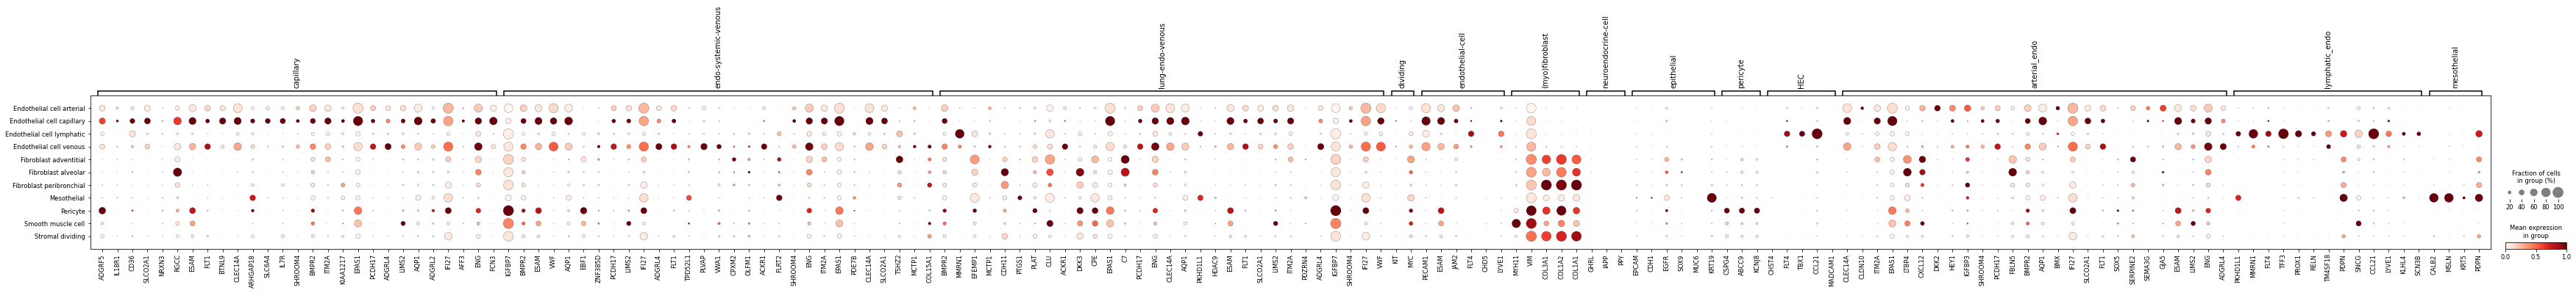

In [126]:
stroma_dict_clean = {}

for k,v in stroma_dict.items():
    stroma_dict_clean[k] = [x for x in v if x in adata.var_names]
sc.pl.dotplot(adata_stroma,stroma_dict_clean, groupby='ann_fine', dendrogram=False,
                 layer=None, standard_scale ='var')

## epithelial

In [127]:
adata_epi = adata[adata.obs['ann_fine'].isin(epi)]
adata_epi

View of AnnData object with n_obs × n_vars = 190414 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_

In [146]:
 
AT1 = ['AGER', 'CLDN18','PDPN','CAV1','CAV2','AQP5']  #10.1183/09031936.04.00096003
AT2 = ['SFTPC','SFTPB','SFTPA1','SFTPA2']  #10.1183/09031936.04.00096003
ciliated = ['PIFO','FOXJ1','HYDIN','CFAP299']
club = ['SCGB3A1','SCGB3A2','SCGB1A1','MUC1','MUC5B']



epi_dict = {
           'AT1':AT1,
           'AT2':AT2,
           'ciliated':ciliated,'club':club,
     'epithelial':['EPCAM','CDH1','EGFR','SOX9','MUC6','MUC5','KRT19'],
    'proliferating':['MKI67','MYC','ROS1']
           }
epi_dict

{'AT1': ['AGER', 'CLDN18', 'PDPN', 'CAV1', 'CAV2', 'AQP5'],
 'AT2': ['SFTPC', 'SFTPB', 'SFTPA1', 'SFTPA2'],
 'ciliated': ['PIFO', 'FOXJ1', 'HYDIN', 'CFAP299'],
 'club': ['SCGB3A1', 'SCGB3A2', 'SCGB1A1', 'MUC1', 'MUC5B'],
 'epithelial': ['EPCAM', 'CDH1', 'EGFR', 'SOX9', 'MUC6', 'MUC5', 'KRT19'],
 'proliferating': ['MKI67', 'MYC', 'ROS1']}

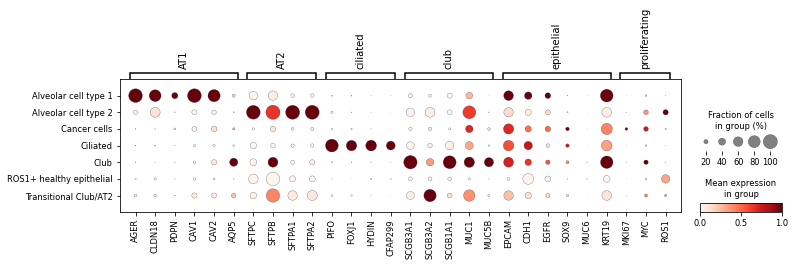

In [147]:
epi_dict_clean = {}

for k,v in epi_dict.items():
    epi_dict_clean[k] = [x for x in v if x in adata.var_names]
sc.pl.dotplot(adata_epi,epi_dict_clean, groupby='ann_fine', dendrogram=False,
                 layer=None, standard_scale ='var')

## define annotations for Spectra

In [149]:
#transform annotations

map_dict_fine = {'NK cell':'NK',
'NK cell dividing':'NK_proliferating',
'T cell CD4':'CD4-T',
'T cell CD4 dividing':'Treg_proliferating',
'T cell CD8 activated':'T',
'T cell CD8 dividing':'CD8-T',
'T cell CD8 effector memory':'CD8-T',
'T cell CD8 naive':'CD8-T',
'T cell CD8 terminally exhausted':'CD8-T',
'T cell NK-like':'CD8-T',
'T cell regulatory':'Treg',
'B cell':'B',
'B cell dividing':'B',
'Plasma cell':'plasma',
'Plasma cell dividing':'plasma_proliferating',
'DC mature':'cDC3',
'Macrophage':'Mac',
'Macrophage alveolar':'Mac',
'Mast cell':'mast',
'Monocyte classical':'M',
'Monocyte non-classical':'M',
'Myeloid dividing':'M',
'Neutrophils':'gran',
'cDC1':'cDC1',
'cDC2':'cDC2',
'pDC':'p-DC',
'Endothelial cell arterial':'endo',
'Endothelial cell capillary':'capillary',
'Endothelial cell lymphatic':'endo-lymphatic',
'Endothelial cell venous':'endo',
'Fibroblast adventitial':'fibro',
'Fibroblast alveolar':'fibro',
'Fibroblast peribronchial':'fibro',
'Mesothelial':'mesothelial',
'Pericyte':'fibro',
'Smooth muscle cell':'smooth-muscle',
'Stromal dividing':'fibro',
'Alveolar cell type 1':'pneumocyte-1',
'Alveolar cell type 2':'pneumocyte-2',
'Cancer cells':'nsclc-carcinoma-cell',
'Ciliated':'ciliated',
'Club':'club',
'ROS1+ healthy epithelial':'lung-epi',
'Transitional Club/AT2':'lung-epi'}

In [150]:
adata.obs['annotation'] = adata.obs['ann_fine'].map(map_dict_fine)
set(adata.obs['annotation'])

{'B',
 'CD4-T',
 'CD8-T',
 'M',
 'Mac',
 'NK',
 'NK_proliferating',
 'T',
 'Treg',
 'Treg_proliferating',
 'cDC1',
 'cDC2',
 'cDC3',
 'capillary',
 'ciliated',
 'club',
 'endo',
 'endo-lymphatic',
 'fibro',
 'gran',
 'lung-epi',
 'mast',
 'mesothelial',
 'nsclc-carcinoma-cell',
 'p-DC',
 'plasma',
 'plasma_proliferating',
 'pneumocyte-1',
 'pneumocyte-2',
 'smooth-muscle'}

In [206]:
#annotations Spectta
Spectra_map = {'B':'B',
 'CD4-T':'CD4-T',
 'CD8-T':'CD8-T',
 'M':'Mac',
 'Mac':'Mac',
 'NK':'NK',
 'NK_proliferating':'NK',
 'T':'T',
 'Treg':'Treg',
 'Treg_proliferating':'Treg',
 'cDC1':'DC',
 'cDC2':'DC',
 'cDC3':'DC',
 'capillary':'endo',
 'ciliated':'epi',
 'club':'epi',
 'endo':'endo',
 'endo-lymphatic':'endo',
 'fibro':'fibro',
 'gran':'gran',
 'lung-epi':'epi',
 'mast':'mast',
 'mesothelial':'epi',
 'nsclc-carcinoma-cell':'epi',
 'p-DC':'DC',
 'plasma':'plasma',
 'plasma_proliferating':'plasma',
 'pneumocyte-1':'epi',
 'pneumocyte-2':'epi',
 'smooth-muscle':'fibro'}

In [207]:
adata.obs['annotation_Spectra'] = adata.obs['annotation'].map(Spectra_map)
set(adata.obs['annotation_Spectra'])

{'B',
 'CD4-T',
 'CD8-T',
 'DC',
 'Mac',
 'NK',
 'T',
 'Treg',
 'endo',
 'epi',
 'fibro',
 'gran',
 'mast',
 'plasma'}

In [ ]:
adata.write(adata_save_path)
print('saved to:',adata_save_path)

In [4]:
adata = sc.read(DATA_DIR + '/TIL-X-NSCLC-X-scRNAseq-X-2022-X-Salcher-X-10.1016_j.ccell.2022.10.008_annotated.h5ad')

Only considering the two last: ['.008_annotated', '.h5ad'].
Only considering the two last: ['.008_annotated', '.h5ad'].


/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## calculate hv genes for Spectra

In [6]:
adata.var['ighm'] = adata.var_names.str.startswith('IGHM')
adata.var['iglc'] = adata.var_names.str.startswith('IGLC')
adata.var['ighg'] = adata.var_names.str.startswith('IGHG')
adata.var['igha'] = adata.var_names.str.startswith('IGHA')
adata.var['ighv'] = adata.var_names.str.startswith('IGHV')
adata.var['iglv'] = adata.var_names.str.startswith('IGLV')
adata.var['igkv'] = adata.var_names.str.startswith('IGKV')
adata.var['trbv'] = adata.var_names.str.startswith('TRBV')
adata.var['trav'] = adata.var_names.str.startswith('TRAV')
adata.var['trgv'] = adata.var_names.str.startswith('TRGV')
adata.var['trdv'] = adata.var_names.str.startswith('TRDV')

adata.var['hb'] = adata.var_names.str.startswith('HB')
adata = adata[:,~(adata.var['hb']|adata.var['ighm']|adata.var['iglc']|adata.var['ighg']|adata.var['igha']|adata.var['ighv']|adata.var['trgv']|adata.var['trdv']|adata.var['iglv']|adata.var['igkv']|adata.var['trav']|adata.var['trbv'])]
    
adata

View of AnnData object with n_obs × n_vars = 1283972 × 17688
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'annotation', 'annotation_Spectra'
    var: 'is_h

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, flavor = "cell_ranger",batch_key='dataset')

/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [ ]:
adata.write(adata_save_path)
print('saved to:',adata_save_path)

## extract and save annotations

In [209]:
annotations = pd.DataFrame(adata.obs[['annotation','ann_fine']])
annotations.columns = ['annotation','cluster']
annotations

,annotation,cluster
001C_AAACCTGCATCGGGTC-0,M,Monocyte non-classical
001C_AAACCTGTCAACACCA-0,Mac,Macrophage alveolar
001C_AAACGGGAGACTAAGT-0,endo-lymphatic,Endothelial cell lymphatic
001C_AAACGGGAGGCTCATT-0,Mac,Macrophage
001C_AAACGGGAGGGAACGG-0,M,Monocyte classical
...,...,...
TTTGTCACATCTATGG-1-38-8,Mac,Macrophage
TTTGTCACATGTTGAC-1-38-8,M,Monocyte classical
TTTGTCAGTGTTGGGA-1-38-8,Mac,Macrophage
TTTGTCATCAGTTTGG-1-38-8,Treg,T cell regulatory


In [ ]:
annotations.to_csv(adata_save_path[:-5]+'.csv')
print('saved to:',adata_save_path[:-5]+'.csv')

## retrieve dictionary for Spectra from cytopus KnowledgeBase

In [211]:
print('all cell types in data are in cytopus KnowledgeBase:',
      len(set(adata.obs['annotation_Spectra']).intersection(set(G.celltypes))) ==len(set(adata.obs['annotation_Spectra'])))

all cell types in data are in cytopus KnowledgeBase: True


In [227]:
#define cell types to retrieve gene sets for
celltype_of_interest = list(set(adata.obs['annotation_Spectra']))
global_celltypes = ['all-cells']


query_depth_parent = {'NK':1,
 'CD4-T':2,
 'B':None,
 'epi':1,
 'plasma':1,
 'mast':None,
 'CD8-T':2,
 'DC':None,
 'fibro':1,
 'Treg':None,
 'T':1,
 'endo':1,
 'gran':None,
 'Mac':1}
#query_depth_child = {'CD4-T':None,'ILC':None}

#retrieve dictionary for Spectra
G.get_celltype_processes(celltype_of_interest,global_celltypes = global_celltypes,
                         get_children=True,get_parents=True,
                         child_depth=1,
                         parent_depth_dict = query_depth_parent,
                        #child_depth_dict = query_depth_child
                        )

cell types of interest share the following children: ['CD4-T', 'Treg', 'plasma', 'CD8-T'] This may be desired.
cell types of interest share the following parents: ['T', 'TNK', 'B', 'all-cells'] This may be desired.


In [249]:
Spectra_dict = {}


for i,v in G.celltype_process_dict.items():
    Spectra_dict[i] = v

In [ ]:
#store Spectra dictionary

import json
jpath = DATA_DIR + 'Spectra_dict_Salcher_2022.json'

with open(jpath, 'w') as f:
    json.dump(Spectra_dict,f)
print('saved data to:',jpath)